In [3]:
from pathlib import Path

base = Path("/Users/wanglibei/Desktop/MNBVC")
folders = ["le", "ge"]

pdf_records = []
for folder in folders:
    for pdf_path in (base / folder).rglob("*.pdf"):
        pdf_records.append({"folder": folder, "path": pdf_path})

In [44]:
pdf_records[0]

{'folder': 'le', 'path': PosixPath('/Users/wanglibei/Desktop/MNBVC/le/98.pdf')}

In [15]:
pdf_records[0]["path"]

PosixPath('/Users/wanglibei/Desktop/MNBVC/le/98.pdf')

In [20]:
def flatten_per_page_features(feature_dict_sample, sample_to_k_page_features=8):
    """
    Flattens list-based per-page features into individual features.
    Assumes each relevant list in feature_dict_sample has exactly num_pages_expected items.
    """
    flattened_features = {}

    # Document level features
    doc_level_features = [
        "num_pages_successfully_sampled",
        "num_unique_image_xrefs",
        "num_junk_image_xrefs",
        "garbled_text_ratio",
        "is_form",
        "creator_or_producer_is_known_scanner",
        "class"
    ]

    # Track which keys were actually used
    used_keys = set()

    for key in doc_level_features:
        if key in feature_dict_sample:
            flattened_features[key] = feature_dict_sample[key]
            used_keys.add(key)

    page_level_features = [
        "page_level_unique_font_counts",
        "page_level_char_counts",
        "page_level_text_box_counts",
        "page_level_avg_text_box_lengths",
        "page_level_text_area_ratios",
        "page_level_hidden_char_counts",
        "page_level_hidden_text_box_counts",
        "page_level_hidden_avg_text_box_lengths",
        "page_level_hidden_text_area_ratios",
        "page_level_image_counts",
        "page_level_non_junk_image_counts",
        "page_level_bitmap_proportions",
        "page_level_max_merged_strip_areas",
        "page_level_drawing_strokes_count",
        "page_level_vector_graphics_obj_count",
    ]

    num_pages = len(feature_dict_sample['page_level_unique_font_counts'])
    page_indices = list(range(num_pages))
    # If we don't have enough pages, resample random pages
    if num_pages < sample_to_k_page_features:
        page_indices += np.random.choice(
            num_pages, sample_to_k_page_features - num_pages, replace=True).tolist()

    for key in page_level_features:
        list_data = feature_dict_sample.get(key)

        for page_idx, ind in enumerate(page_indices):
            value = list_data[ind]
            flattened_features[f'{key}_page{page_idx+1}'] = value
        used_keys.add(key)

    # Check for unused keys
    all_input_keys = set(feature_dict_sample.keys())
    unused_keys = all_input_keys - used_keys
    # if unused_keys:
    #     print(f"Warning: The following keys were not used in flattening: {unused_keys}")

    return flattened_features

In [8]:
import pandas as pd

pdf_path_db = pd.DataFrame(pdf_records)
pdf_path_db.head()

pdf_path_db.to_csv(base / "pdf_path_db.csv", index=False)

In [9]:
import random
from collections import Counter
import pymupdf  # PyMuPDF

class PDFFeatureExtractor():
    JUNK_IMAGE_THRESHOLD_RATIO = 0.5
    JUNK_IMAGE_MIN_PAGES_FOR_THRESHOLD = 3
    MERGE_MAX_OFFSET = 5
    MERGE_MAX_GAP = 2
    # Define known scanner strings for creator/producer check
    KNOWN_SCANNER_STRINGS = [
        "scanner", "scan", "epson", "hp scanjet", "canon", "fujitsu",
        "kodak", "brother", "xerox", "lexmark", "kmc", "kofax", "ricoh",
        "iris", "capturedocument", "paperport", "readiris", "simpleocr"
    ]

    def __init__(self, num_pages_to_sample: int = 5, num_chunks: int = 1):
        if not isinstance(num_pages_to_sample, int):
            raise ValueError("num_pages_to_sample must be an integer.")
        self.num_pages_to_sample = num_pages_to_sample
        self.num_chunks = num_chunks

    def get_garbled_text_per_age(self, doc: pymupdf.Document):
        all_text = []
        garbled_text = []
        for page in doc:
            page_text = page.get_text(
                "text", flags=pymupdf.TEXT_PRESERVE_WHITESPACE | pymupdf.TEXT_MEDIABOX_CLIP)
            all_text.append(len(page_text))
            garbled_text.append(page_text.count(chr(0xfffd)))
        return all_text, garbled_text

    def _get_sampled_page_indices(self, doc: pymupdf.Document) -> list[list[int]]:
        total_pages = len(doc)
        if total_pages == 0:
            return []

        # If num_pages_to_sample is non-positive, return empty list
        if self.num_pages_to_sample <= 0:
            return []

        # Sample indices without replacement
        available_indices = list(range(total_pages))
        sampled_indices = []

        # Sample up to num_chunks, each with num_pages_to_sample indices
        if self.num_chunks == -1:
            num_chunks = len(available_indices) // self.num_pages_to_sample + 1
        else:
            num_chunks = self.num_chunks

        for _ in range(num_chunks):
            # Break if not enough pages left for another chunk
            if len(available_indices) == 0:
                break

            # Sample min of available pages and pages_per_chunk
            chunk_size = min(self.num_pages_to_sample, len(available_indices))
            chunk = random.sample(available_indices, chunk_size)

            # Remove sampled indices from available pool
            for idx in chunk:
                available_indices.remove(idx)

            sampled_indices.append(sorted(chunk))

        return sampled_indices

    def _heuristic_merge_image_strips_on_page(self, single_page_image_list: list, page_width: float, page_height: float) -> list:
        if not single_page_image_list:
            return []

        page_images_deduped_by_bbox = []
        dedup_bboxes = set()
        for img_data in single_page_image_list:
            bbox_tuple = (img_data[0], img_data[1], img_data[2], img_data[3])
            if bbox_tuple not in dedup_bboxes:
                dedup_bboxes.add(bbox_tuple)
                page_images_deduped_by_bbox.append(img_data)

        if not page_images_deduped_by_bbox:
            return []

        page_images_deduped_by_bbox.sort(key=lambda img: (img[1], img[0]))

        if not page_images_deduped_by_bbox:
            return []
        current_page_merged_list = [page_images_deduped_by_bbox[0]]

        for img_to_potentially_merge in page_images_deduped_by_bbox[1:]:
            x0_curr, y0_curr, x1_curr, y1_curr, imgid_curr = img_to_potentially_merge
            last_merged_img = current_page_merged_list[-1]
            x0_last, y0_last, x1_last, y1_last, _ = last_merged_img

            img_curr_width = abs(x1_curr - x0_curr)
            img_curr_height = abs(y1_curr - y0_curr)

            full_width_curr = page_width > 0 and (
                img_curr_width >= page_width * 0.9)
            full_height_curr = page_height > 0 and (
                img_curr_height >= page_height * 0.9)

            can_merge = False
            if full_width_curr:
                is_vertically_aligned_and_close = \
                    (abs(x0_last - x0_curr) <= self.MERGE_MAX_OFFSET) and \
                    (abs(x1_last - x1_curr) <= self.MERGE_MAX_OFFSET) and \
                    (abs(y0_curr - y1_last) <= self.MERGE_MAX_GAP)
                if is_vertically_aligned_and_close:
                    can_merge = True

            if not can_merge and full_height_curr:
                is_horizontally_aligned_and_close = \
                    (abs(y0_last - y0_curr) <= self.MERGE_MAX_OFFSET) and \
                    (abs(y1_last - y1_curr) <= self.MERGE_MAX_OFFSET) and \
                    (abs(x0_curr - x1_last) <= self.MERGE_MAX_GAP)
                if is_horizontally_aligned_and_close:
                    can_merge = True

            if can_merge:
                current_page_merged_list[-1] = [
                    min(x0_curr, x0_last), min(y0_curr, y0_last),
                    max(x1_curr, x1_last), max(y1_curr, y1_last),
                    imgid_curr
                ]
            else:
                current_page_merged_list.append(img_to_potentially_merge)

        return current_page_merged_list

    def _extract_document_level_stats_from_sampled_pages(self, doc: pymupdf.Document, sampled_page_indices: list[int]) -> dict:
        # This function will calculate doc-level stats based ONLY on the sampled pages.
        doc_stats = {
            # "num_unique_image_xrefs": 0,
            # "num_junk_image_xrefs": 0,
            # This will be calculated and returned for use in page-level stats
            "junk_image_xrefs_list": []
        }

        if not sampled_page_indices:  # No pages sampled or document is empty
            return doc_stats | {"junk_image_xrefs_list": []}

        # Stores xref for each instance across sampled pages
        img_xrefs_all_instances_sampled = []
        # Stores set of unique xrefs per sampled_page_idx
        page_unique_xrefs_map_sampled = {}

        for page_idx in sampled_page_indices:
            try:
                page = doc.load_page(page_idx)
                current_page_unique_xrefs = set()
                image_definitions_on_page = page.get_images(full=False)

                for img_def_tuple in image_definitions_on_page:
                    xref = img_def_tuple[0]
                    if xref == 0:
                        continue
                    current_page_unique_xrefs.add(xref)
                    img_xrefs_all_instances_sampled.append(xref)
                page_unique_xrefs_map_sampled[page_idx] = current_page_unique_xrefs
            except Exception as e:
                print(f"Error processing page {page_idx}")
                # print(f"Warning: Could not get image info for page {page_idx} in doc stats: {e}")
                page_unique_xrefs_map_sampled[page_idx] = set()

        if not img_xrefs_all_instances_sampled:
            return doc_stats | {"junk_image_xrefs_list": []}

        uniq_img_xrefs_doc_wide_sampled = set(img_xrefs_all_instances_sampled)
        doc_stats["num_unique_image_xrefs"] = len(
            uniq_img_xrefs_doc_wide_sampled)

        xref_counts_across_sampled_pages = Counter()
        for page_xrefs_set in page_unique_xrefs_map_sampled.values():
            xref_counts_across_sampled_pages.update(page_xrefs_set)

        num_sampled_pages_for_junk_calc = len(sampled_page_indices)
        min_page_occurrence_threshold = max(
            num_sampled_pages_for_junk_calc * self.JUNK_IMAGE_THRESHOLD_RATIO,
            float(self.JUNK_IMAGE_MIN_PAGES_FOR_THRESHOLD)
        )
        # Ensure threshold is not greater than the number of sampled pages
        min_page_occurrence_threshold = num_sampled_pages_for_junk_calc

        current_junk_xrefs_list = []
        for xref, count_on_pages in xref_counts_across_sampled_pages.items():
            if count_on_pages >= min_page_occurrence_threshold and num_sampled_pages_for_junk_calc >= self.JUNK_IMAGE_MIN_PAGES_FOR_THRESHOLD:
                current_junk_xrefs_list.append(xref)

        # If only one page sampled, no image can be junk by this definition
        if num_sampled_pages_for_junk_calc < self.JUNK_IMAGE_MIN_PAGES_FOR_THRESHOLD:
            current_junk_xrefs_list = []

        doc_stats["num_junk_image_xrefs"] = len(current_junk_xrefs_list)

        return doc_stats | {"junk_image_xrefs_list": current_junk_xrefs_list}

    def _check_creator_producer_scanner(self, doc: pymupdf.Document) -> bool:
        metadata = doc.metadata
        creator = metadata.get("creator", "").lower()
        producer = metadata.get("producer", "").lower()
        for scanner_keyword in self.KNOWN_SCANNER_STRINGS:
            if scanner_keyword in creator or scanner_keyword in producer:
                return True
        return False

    def extract_all_features(self, doc: pymupdf.Document) -> list[dict]:
        sampled_page_indices_to_try = self._get_sampled_page_indices(doc)

        return [self.compute_features_per_chunk(doc, indices) for indices in sampled_page_indices_to_try]

    def compute_features_per_chunk(self, doc: pymupdf.Document, sampled_page_indices_to_try: list[int]) -> dict:
        features = {
            "is_form": False,
            "creator_or_producer_is_known_scanner": False,
            "garbled_text_ratio": 0,
            # Page level stats
            "page_level_unique_font_counts": [],
            "page_level_char_counts": [],
            "page_level_text_box_counts": [],
            "page_level_avg_text_box_lengths": [],
            "page_level_text_area_ratios": [],
            "page_level_hidden_char_counts": [],
            "page_level_hidden_text_box_counts": [],
            "page_level_hidden_avg_text_box_lengths": [],
            "page_level_hidden_text_area_ratios": [],
            "page_level_image_counts": [],
            "page_level_non_junk_image_counts": [],
            "page_level_bitmap_proportions": [],
            "page_level_max_merged_strip_areas": [],
            "page_level_drawing_strokes_count": [],
            "page_level_vector_graphics_obj_count": [],
            "num_pages_successfully_sampled": 0,
            "num_pages_requested_for_sampling": 0,
            "sampled_page_indices": []
        }

        features["num_pages_requested_for_sampling"] = len(
            sampled_page_indices_to_try)
        if not sampled_page_indices_to_try:  # No pages to sample
            return features

        # 2. Extract document-level stats based *only* on these sampled pages
        doc_level_stats_and_junk_list = self._extract_document_level_stats_from_sampled_pages(
            doc, sampled_page_indices_to_try)
        # features["num_unique_image_xrefs"] = doc_level_stats_and_junk_list["num_unique_image_xrefs"]
        # features["num_junk_image_xrefs"] = doc_level_stats_and_junk_list["num_junk_image_xrefs"]

        junk_image_xrefs_from_sampled = set(
            doc_level_stats_and_junk_list.get("junk_image_xrefs_list", []))

        # 3. Document-level miscellaneous features
        # doc.is_form can be None
        features["is_form"] = bool(
            doc.is_form_pdf) if doc.is_form_pdf is not None else False
        features["creator_or_producer_is_known_scanner"] = self._check_creator_producer_scanner(
            doc)

        # --- Garbled text ratio ---
        all_text, garbled_text = self.get_garbled_text_per_age(doc)
        all_text_sum = sum(all_text)
        garbled_text_sum = sum(garbled_text)
        if all_text_sum == 0:
            features["global_garbled_text_ratio"] = 0
        else:
            features["global_garbled_text_ratio"] = garbled_text_sum / all_text_sum

        sampled_garbled_text = sum([garbled_text[i]
                                   for i in sampled_page_indices_to_try])
        sampled_all_text_sum = sum([all_text[i]
                                   for i in sampled_page_indices_to_try])
        if sampled_all_text_sum == 0:
            features["garbled_text_ratio"] = 0
        else:
            features["garbled_text_ratio"] = sampled_garbled_text / \
                sampled_all_text_sum

        # 4. Page-level stats for sampled pages
        for page_idx in sampled_page_indices_to_try:
            try:
                page = doc.load_page(page_idx)
            except Exception:
                print(f"Error processing page {page_idx}")
                # If page load fails, we don't increment successfully_sampled count
                # and don't append to page_level lists for this page.
                # This means lists might be shorter than num_pages_requested_for_sampling.
                # Alternatively, append default/None values if strict list length is needed.
                continue

            features["sampled_page_indices"].append(page_idx)
            features["num_pages_successfully_sampled"] += 1

            page_rect_obj = page.rect
            page_area_pts = float(page_rect_obj.width * page_rect_obj.height)
            if page_area_pts == 0:
                page_area_pts = 1.0  # Avoid division by zero

            # --- Text features ---
            current_page_fonts = set()
            try:
                for fi in page.get_fonts(full=True):
                    if len(fi) > 3 and fi[3]:  # Font name
                        current_page_fonts.add(fi[3])
            except Exception:
                print(f"Error processing page {page_idx}")
                pass

            features["page_level_unique_font_counts"].append(
                len(current_page_fonts))

            page_char_count = 0
            page_text_total_area = 0
            page_text_box_count = 0
            page_hidden_total_area = 0
            page_hidden_char_count = 0
            page_hidden_box_count = 0

            for tr in page.get_texttrace():
                n = len([c[0] for c in tr.get("chars", [])])

                # --- hidden‑text tests ---------------------------------------------------
                if tr.get("type") == 3 or tr.get("opacity", 1.0) == 0:
                    page_hidden_char_count += n
                    page_hidden_total_area += (tr.get("bbox")[2] - tr.get(
                        "bbox")[0]) * (tr.get("bbox")[3] - tr.get("bbox")[1])
                    page_hidden_box_count += 1
                else:
                    page_char_count += n
                    page_text_total_area += (tr.get("bbox")[2] - tr.get(
                        "bbox")[0]) * (tr.get("bbox")[3] - tr.get("bbox")[1])
                    page_text_box_count += 1

            # -- append to your feature lists --------------------------------------------
            features["page_level_char_counts"].append(page_char_count)
            features["page_level_text_box_counts"].append(page_text_box_count)
            features["page_level_avg_text_box_lengths"].append(
                page_text_total_area / page_text_box_count if page_text_box_count else 0.0)
            features["page_level_text_area_ratios"].append(
                page_text_total_area / page_area_pts if page_area_pts else 0.0)

            # hidden text features
            features["page_level_hidden_char_counts"].append(
                page_hidden_char_count)
            features["page_level_hidden_text_box_counts"].append(
                page_hidden_box_count)
            features["page_level_hidden_avg_text_box_lengths"].append(
                page_hidden_total_area / page_hidden_box_count if page_hidden_box_count else 0.0)
            features["page_level_hidden_text_area_ratios"].append(
                page_hidden_total_area / page_area_pts if page_area_pts else 0.0)

            # --- Image features ---
            page_total_image_instances = 0
            page_non_junk_image_instances = 0
            non_junk_rects_for_strip_merge = []

            try:
                image_definitions_on_page = page.get_images(full=False)
                for img_def_tuple in image_definitions_on_page:
                    xref = img_def_tuple[0]
                    if xref == 0:
                        continue

                    image_rects_on_page = page.get_image_rects(
                        xref, transform=False)
                    page_total_image_instances += len(image_rects_on_page)

                    if xref not in junk_image_xrefs_from_sampled:
                        page_non_junk_image_instances += len(
                            image_rects_on_page)
                        for rect_obj in image_rects_on_page:  # rect_obj is a pymupdf.Rect
                            # Ensure rect has positive area if needed for some calculations
                            if rect_obj.is_empty or rect_obj.is_infinite:
                                continue
                            bbox_list = [rect_obj.x0, rect_obj.y0,
                                         rect_obj.x1, rect_obj.y1]
                            non_junk_rects_for_strip_merge.append(
                                bbox_list + [xref])
            except Exception:
                print(f"Error processing page {page_idx}")
                pass

            features["page_level_image_counts"].append(
                page_total_image_instances)
            features["page_level_non_junk_image_counts"].append(
                page_non_junk_image_instances)

            merged_strip_bboxes_original = self._heuristic_merge_image_strips_on_page(
                non_junk_rects_for_strip_merge, page_rect_obj.width, page_rect_obj.height
            )
            merged_strip_areas_original = [
                abs(b[2]-b[0])*abs(b[3]-b[1]) for b in merged_strip_bboxes_original]

            if merged_strip_areas_original:
                features["page_level_max_merged_strip_areas"].append(
                    max(merged_strip_areas_original) / page_area_pts if page_area_pts > 0 else 0.0)
                features["page_level_bitmap_proportions"].append(
                    sum(merged_strip_areas_original) / page_area_pts if page_area_pts > 0 else 0.0)
            else:
                features["page_level_max_merged_strip_areas"].append(0.0)
                features["page_level_bitmap_proportions"].append(0.0)

            # --- Drawings and Vector Graphics ---
            drawings_stroke_count = 0
            vector_graphics_obj_count = 0  # Could be paths, fills etc.
            try:
                drawings = page.get_cdrawings()  # list of paths
                vector_graphics_obj_count = len(
                    drawings)  # Each path is an object
                for path in drawings:
                    # 'items' contains sequence of path construction operators like ('l', x, y) or ('c', ...)
                    # A simple heuristic: count line segments or curves as strokes.
                    # This is a simplification.
                    for item in path.get("items", []):
                        if item[0] in ['l', 'c', 'q']:  # line, curve, quad
                            drawings_stroke_count += 1
                    # also consider rects, quads if drawn as outlines
                    if path.get("rect") or path.get("quad"):
                        # stroked, not filled or transparent
                        if path.get("stroke_opacity", 1) > 0 and path.get("color"):

                            drawings_stroke_count += 1  # count the shape as one stroke set
            except Exception:
                print(f"Error processing page {page_idx}")
            features["page_level_drawing_strokes_count"].append(
                drawings_stroke_count)
            features["page_level_vector_graphics_obj_count"].append(
                vector_graphics_obj_count)

        return features

    def extract_features(self, doc: pymupdf.Document):
        main_features = self.extract_all_features(doc)
        return main_features

In [10]:
extractor = PDFFeatureExtractor(num_pages_to_sample=8, num_chunks=1)

In [16]:
pdf_bytes = pdf_records[0]["path"].read_bytes()

In [ ]:
prob_records = []


model = XGBClassifier()
model.load_model("xgb_ocr_classifier/xgb_classifier.ubj")

for record in pdf_records:
    pdf_path = record["path"]
    pdf_bytes = pdf_path.read_bytes()
    with pymupdf.open(stream=pdf_bytes, filetype="pdf") as doc:
        features_raw = extractor.extract_features(doc)
        features = flatten_per_page_features(features_raw[0], sample_to_k_page_features=8)
        ocr_prob = model.predict_proba(pd.DataFrame([features]))[0][1]
    prob_records.append({"path": pdf_path, "ocr_prob": ocr_prob})

prob_df = pd.DataFrame(prob_records)
prob_df.head(20)

In [17]:
import io

pymupdf_doc = pymupdf.open(stream=io.BytesIO(pdf_bytes), filetype="pdf")

In [18]:
features_raw = extractor.extract_features(pymupdf_doc)

In [25]:
features_raw

[{'is_form': False,
  'creator_or_producer_is_known_scanner': False,
  'garbled_text_ratio': 0,
  'page_level_unique_font_counts': [0],
  'page_level_char_counts': [0],
  'page_level_text_box_counts': [0],
  'page_level_avg_text_box_lengths': [0.0],
  'page_level_text_area_ratios': [0.0],
  'page_level_hidden_char_counts': [0],
  'page_level_hidden_text_box_counts': [0],
  'page_level_hidden_avg_text_box_lengths': [0.0],
  'page_level_hidden_text_area_ratios': [0.0],
  'page_level_image_counts': [11],
  'page_level_non_junk_image_counts': [11],
  'page_level_bitmap_proportions': [1.048705827247704],
  'page_level_max_merged_strip_areas': [1.0020260421025242],
  'page_level_drawing_strokes_count': [0],
  'page_level_vector_graphics_obj_count': [0],
  'num_pages_successfully_sampled': 1,
  'num_pages_requested_for_sampling': 1,
  'sampled_page_indices': [0],
  'global_garbled_text_ratio': 0}]

In [27]:
import numpy as np

features = flatten_per_page_features(
    features_raw[0], sample_to_k_page_features=8)

In [30]:
len(features)

124

In [33]:
features_df = pd.DataFrame([features])  

In [35]:
from xgboost import XGBClassifier


In [36]:

model = XGBClassifier()
model.load_model("xgb_ocr_classifier/xgb_classifier.ubj")

In [37]:
ocr_prob = model.predict_proba(pd.DataFrame([features]))[0][1]

In [39]:
print(ocr_prob)

0.89746636


In [45]:
prob_records = []


model = XGBClassifier()
model.load_model("xgb_ocr_classifier/xgb_classifier.ubj")

for record in pdf_records:
    pdf_path = record["path"]
    pdf_bytes = pdf_path.read_bytes()
    with pymupdf.open(stream=pdf_bytes, filetype="pdf") as doc:
        features_raw = extractor.extract_features(doc)
        features = flatten_per_page_features(
            features_raw[0], sample_to_k_page_features=8)
        ocr_prob = model.predict_proba(pd.DataFrame([features]))[0][1]
    prob_records.append({"path": pdf_path, "ocr_prob": ocr_prob})

prob_df = pd.DataFrame(prob_records)
prob_df.head(20)

MuPDF error: syntax error: cannot find ExtGState resource 'GS12'

MuPDF error: syntax error: cannot find ExtGState resource 'GS17'

MuPDF error: syntax error: cannot find ExtGState resource 'GS22'

MuPDF error: syntax error: cannot find ExtGState resource 'GS27'

MuPDF error: syntax error: cannot find ExtGState resource 'GS32'

MuPDF error: syntax error: cannot find ExtGState resource 'GS37'

MuPDF error: syntax error: cannot find ExtGState resource 'GS42'

MuPDF error: syntax error: cannot find ExtGState resource 'GS47'

MuPDF error: syntax error: cannot find ExtGState resource 'GS52'

MuPDF error: syntax error: cannot find ExtGState resource 'GS57'

MuPDF error: syntax error: cannot find ExtGState resource 'GS62'

MuPDF error: syntax error: cannot find ExtGState resource 'GS67'

MuPDF error: syntax error: cannot find ExtGState resource 'GS72'

MuPDF error: syntax error: cannot find ExtGState resource 'GS77'

MuPDF error: syntax error: cannot find ExtGState resource 'GS82'

MuPDF erro

,path,ocr_prob
0,/Users/wanglibei/Desktop/MNBVC/le/98.pdf,0.897466
1,/Users/wanglibei/Desktop/MNBVC/le/99.pdf,0.993762
2,/Users/wanglibei/Desktop/MNBVC/le/100.pdf,0.942853
3,/Users/wanglibei/Desktop/MNBVC/le/97.pdf,0.942853
4,/Users/wanglibei/Desktop/MNBVC/le/96.pdf,0.942853
5,/Users/wanglibei/Desktop/MNBVC/le/94.pdf,0.942853
6,/Users/wanglibei/Desktop/MNBVC/le/95.pdf,0.942853
7,/Users/wanglibei/Desktop/MNBVC/le/92.pdf,0.988465
8,/Users/wanglibei/Desktop/MNBVC/le/93.pdf,0.942853
9,/Users/wanglibei/Desktop/MNBVC/ge/98.pdf,0.000031


In [46]:
le_df = prob_df[prob_df["path"].astype(
    str).str.contains("/le/")].reset_index(drop=True)
ge_df = prob_df[prob_df["path"].astype(
    str).str.contains("/ge/")].reset_index(drop=True)

In [48]:
le_df.sort_values("ocr_prob", ascending=False).head(10)

,path,ocr_prob
1,/Users/wanglibei/Desktop/MNBVC/le/99.pdf,0.993762
7,/Users/wanglibei/Desktop/MNBVC/le/92.pdf,0.988465
2,/Users/wanglibei/Desktop/MNBVC/le/100.pdf,0.942853
3,/Users/wanglibei/Desktop/MNBVC/le/97.pdf,0.942853
4,/Users/wanglibei/Desktop/MNBVC/le/96.pdf,0.942853
5,/Users/wanglibei/Desktop/MNBVC/le/94.pdf,0.942853
6,/Users/wanglibei/Desktop/MNBVC/le/95.pdf,0.942853
8,/Users/wanglibei/Desktop/MNBVC/le/93.pdf,0.942853
0,/Users/wanglibei/Desktop/MNBVC/le/98.pdf,0.897466


In [49]:
ge_df.sort_values("ocr_prob", ascending=False).head(10)

,path,ocr_prob
7,/Users/wanglibei/Desktop/MNBVC/ge/91.pdf,0.016350
3,/Users/wanglibei/Desktop/MNBVC/ge/97.pdf,0.010925
8,/Users/wanglibei/Desktop/MNBVC/ge/90.pdf,0.009072
5,/Users/wanglibei/Desktop/MNBVC/ge/94.pdf,0.006732
6,/Users/wanglibei/Desktop/MNBVC/ge/95.pdf,0.005882
4,/Users/wanglibei/Desktop/MNBVC/ge/96.pdf,0.002588
1,/Users/wanglibei/Desktop/MNBVC/ge/99.pdf,0.000910
9,/Users/wanglibei/Desktop/MNBVC/ge/92.pdf,0.000194
10,/Users/wanglibei/Desktop/MNBVC/ge/93.pdf,0.000078
2,/Users/wanglibei/Desktop/MNBVC/ge/100.pdf,0.000052


In [ ]:
pdf_path = Path("/Users/wanglibei/Desktop/MNBVC/le/98.pdf")

with pymupdf.open(pdf_path) as doc:
    print(f"Pages: {doc.page_count}")
    for page_index in range(doc.page_count):
        page = doc.load_page(page_index)
        text = page.get_text("blocks") 
        print(f"\n--- Page {page_index + 1} ---\n{text}")

Pages: 1

--- Page 1 ---
[]


In [ ]:
pdf_path = Path("/Users/wanglibei/Desktop/MNBVC/ge/91.pdf")

with pymupdf.open(pdf_path) as doc:
    print(f"Pages: {doc.page_count}")
    for page_index in range(doc.page_count):
        page = doc.load_page(page_index)
        text = page.get_text("text")  
        print(f"\n--- Page {page_index + 1} ---\n{text}")

Pages: 164

--- Page 1 ---
常　用　漢　字　表
　前　書　き
１　この表は，法令，公⽤⽂書，新聞，雑誌，放送など，⼀般の社会⽣活におい
て，現代の国語を書き表す場合の漢字使⽤の⽬安を⽰すものである。
２　この表は，科学，技術，芸術その他の各種専⾨分野や個々⼈の表記にまで及ぼ
そうとするものではない。ただし，専⾨分野の語であっても，⼀般の社会⽣活と
密接に関連する語の表記については，この表を参考とすることが望ましい。
３　この表は，都道府県名に⽤いる漢字及びそれに準じる漢字を除き，固有名詞を
対象とするものではない。
４　この表は，過去の著作や⽂書における漢字使⽤を否定するものではない。
５　この表の運⽤に当たっては，個々の事情に応じて適切な考慮を加える余地のあ
るものである。
　表の見方及び使い方
１　この表は，「本表」と「付表」とから成る。
２　「本表」には，字種2136 字を掲げ，字体，音訓，語例等を併せ示した。
３　漢字欄には，字種と字体を示した。字種は字音によって五十音順に並べた。
　同音の場合はおおむね字画の少ないものを先にした。字音を取り上げていないもの
は，字訓によった。
４　字体は文字の骨組みであるが，便宜上，明
みん
朝体のうちの一種を例に用いて「印刷
文字における現代の通用字体」を示した。
５　「しんにゅう／しょくへん」に関係する字のうち，「辶／𩙿」の字形が通用字体
である字については，「辶／飠」の字形を角括弧に入れて許容字体として併せ示し
た。当該の字に関して，現に印刷文字として許容字体を用いている場合，通用字体
である「辶／𩙿」の字形に改める必要はない。これを「字体の許容」と呼ぶ。
　　なお，当該の字の備考欄には，角括弧に入れたものが許容字体であることを注記
した。また，通用字体の「謎」における「謎」についても「しんにゅう／しょくへ
ん」の扱いに準じるものとして，同様の注記を加えてある。
６　丸括弧に入れて添えたものは，いわゆる康熙
き
字典体である。これは，明治以来行
われてきた活字の字体とのつながりを示すために参考として添えたものであるが，
著しい差異のないものは省いた。


--- Page 2 ---
７　音訓欄には，音訓を示した。字音は片仮名で，字訓は平仮名で示した。１字下げ
で示した音訓は，特

In [55]:
features

{'num_pages_successfully_sampled': 8,
 'garbled_text_ratio': 0.0,
 'is_form': False,
 'creator_or_producer_is_known_scanner': False,
 'page_level_unique_font_counts_page1': 3,
 'page_level_unique_font_counts_page2': 4,
 'page_level_unique_font_counts_page3': 3,
 'page_level_unique_font_counts_page4': 3,
 'page_level_unique_font_counts_page5': 4,
 'page_level_unique_font_counts_page6': 3,
 'page_level_unique_font_counts_page7': 3,
 'page_level_unique_font_counts_page8': 1,
 'page_level_char_counts_page1': 1568,
 'page_level_char_counts_page2': 1986,
 'page_level_char_counts_page3': 1309,
 'page_level_char_counts_page4': 1862,
 'page_level_char_counts_page5': 1785,
 'page_level_char_counts_page6': 1611,
 'page_level_char_counts_page7': 772,
 'page_level_char_counts_page8': 1394,
 'page_level_text_box_counts_page1': 22,
 'page_level_text_box_counts_page2': 12,
 'page_level_text_box_counts_page3': 16,
 'page_level_text_box_counts_page4': 14,
 'page_level_text_box_counts_page5': 16,
 'page_

In [57]:
features_df.columns

Index(['num_pages_successfully_sampled', 'garbled_text_ratio', 'is_form',
       'creator_or_producer_is_known_scanner',
       'page_level_unique_font_counts_page1',
       'page_level_unique_font_counts_page2',
       'page_level_unique_font_counts_page3',
       'page_level_unique_font_counts_page4',
       'page_level_unique_font_counts_page5',
       'page_level_unique_font_counts_page6',
       ...
       'page_level_drawing_strokes_count_page7',
       'page_level_drawing_strokes_count_page8',
       'page_level_vector_graphics_obj_count_page1',
       'page_level_vector_graphics_obj_count_page2',
       'page_level_vector_graphics_obj_count_page3',
       'page_level_vector_graphics_obj_count_page4',
       'page_level_vector_graphics_obj_count_page5',
       'page_level_vector_graphics_obj_count_page6',
       'page_level_vector_graphics_obj_count_page7',
       'page_level_vector_graphics_obj_count_page8'],
      dtype='object', length=124)

In [ ]:
importances = model.feature_importances_
feature_names = features_df.columns  
feature_importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values("importance", ascending=False)

In [64]:
feature_importance_df.head(10)

,feature,importance
40,page_level_text_area_ratios_page5,0.181337
18,page_level_char_counts_page7,0.127998
42,page_level_text_area_ratios_page7,0.091196
36,page_level_text_area_ratios_page1,0.078033
19,page_level_char_counts_page8,0.059096
37,page_level_text_area_ratios_page2,0.034772
107,page_level_max_merged_strip_areas_page8,0.034519
88,page_level_non_junk_image_counts_page5,0.020070
3,creator_or_producer_is_known_scanner,0.017402
74,page_level_hidden_text_area_ratios_page7,0.011853


In [72]:
feature_importance_df.tail(10)

,feature,importance
45,page_level_hidden_char_counts_page2,0.0
111,page_level_drawing_strokes_count_page4,0.0
110,page_level_drawing_strokes_count_page3,0.0
46,page_level_hidden_char_counts_page3,0.0
67,page_level_hidden_avg_text_box_lengths_page8,0.0
48,page_level_hidden_char_counts_page5,0.0
91,page_level_non_junk_image_counts_page8,0.0
64,page_level_hidden_avg_text_box_lengths_page5,0.0
61,page_level_hidden_avg_text_box_lengths_page2,0.0
62,page_level_hidden_avg_text_box_lengths_page3,0.0


In [60]:
feature_rows = []

for record in pdf_records:
    pdf_path = record["path"]
    pdf_bytes = pdf_path.read_bytes()
    with pymupdf.open(stream=pdf_bytes, filetype="pdf") as doc:
        features_raw = extractor.extract_features(doc)
        features = flatten_per_page_features(
            features_raw[0], sample_to_k_page_features=8)

    ocr_prob = model.predict_proba(pd.DataFrame([features]))[0][1]
    prob_records.append({"path": pdf_path, "ocr_prob": ocr_prob})

    feature_rows.append({"path": str(pdf_path), **features})

MuPDF error: syntax error: cannot find ExtGState resource 'GS12'

MuPDF error: syntax error: cannot find ExtGState resource 'GS17'

MuPDF error: syntax error: cannot find ExtGState resource 'GS22'

MuPDF error: syntax error: cannot find ExtGState resource 'GS27'

MuPDF error: syntax error: cannot find ExtGState resource 'GS32'

MuPDF error: syntax error: cannot find ExtGState resource 'GS37'

MuPDF error: syntax error: cannot find ExtGState resource 'GS42'

MuPDF error: syntax error: cannot find ExtGState resource 'GS47'

MuPDF error: syntax error: cannot find ExtGState resource 'GS52'

MuPDF error: syntax error: cannot find ExtGState resource 'GS57'

MuPDF error: syntax error: cannot find ExtGState resource 'GS62'

MuPDF error: syntax error: cannot find ExtGState resource 'GS67'

MuPDF error: syntax error: cannot find ExtGState resource 'GS72'

MuPDF error: syntax error: cannot find ExtGState resource 'GS77'

MuPDF error: syntax error: cannot find ExtGState resource 'GS82'

MuPDF erro

In [61]:
features_df = pd.DataFrame(feature_rows)


In [ ]:


numeric_cols = features_df.select_dtypes(include=["number", "bool"]).columns
corr_matrix = features_df[numeric_cols].corr(method="pearson")

print(corr_matrix.head())

                                      num_pages_successfully_sampled  \
num_pages_successfully_sampled                              1.000000   
garbled_text_ratio                                               NaN   
is_form                                                          NaN   
creator_or_producer_is_known_scanner                             NaN   
page_level_unique_font_counts_page1                        -0.113333   

                                      garbled_text_ratio  is_form  \
num_pages_successfully_sampled                       NaN      NaN   
garbled_text_ratio                                   NaN      NaN   
is_form                                              NaN      NaN   
creator_or_producer_is_known_scanner                 NaN      NaN   
page_level_unique_font_counts_page1                  NaN      NaN   

                                      creator_or_producer_is_known_scanner  \
num_pages_successfully_sampled                                         NaN

In [63]:
corr_matrix

,num_pages_successfully_sampled,garbled_text_ratio,is_form,creator_or_producer_is_known_scanner,page_level_unique_font_counts_page1,page_level_unique_font_counts_page2,page_level_unique_font_counts_page3,page_level_unique_font_counts_page4,page_level_unique_font_counts_page5,page_level_unique_font_counts_page6,...,page_level_drawing_strokes_count_page7,page_level_drawing_strokes_count_page8,page_level_vector_graphics_obj_count_page1,page_level_vector_graphics_obj_count_page2,page_level_vector_graphics_obj_count_page3,page_level_vector_graphics_obj_count_page4,page_level_vector_graphics_obj_count_page5,page_level_vector_graphics_obj_count_page6,page_level_vector_graphics_obj_count_page7,page_level_vector_graphics_obj_count_page8
num_pages_successfully_sampled,1.000000,NaN,NaN,NaN,-0.113333,-0.023199,-0.057847,-0.099913,-0.014749,-0.071095,...,0.065686,-0.004017,-0.323819,-0.295204,-0.289344,-0.278698,-0.298350,-0.242374,-0.266650,-0.298790
garbled_text_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_form,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
creator_or_producer_is_known_scanner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
page_level_unique_font_counts_page1,-0.113333,NaN,NaN,NaN,1.000000,0.963090,0.918831,0.916231,0.969183,0.947078,...,0.190658,0.048620,0.155919,0.161683,0.147942,0.159536,0.150161,0.224529,0.190720,0.141040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
page_level_vector_graphics_obj_count_page4,-0.278698,NaN,NaN,NaN,0.159536,0.080014,0.076751,0.146165,0.072476,0.102018,...,0.642686,0.663894,0.966970,0.992832,0.994764,1.000000,0.993720,0.979194,0.991521,0.981596
page_level_vector_graphics_obj_count_page5,-0.298350,NaN,NaN,NaN,0.150161,0.068061,0.078097,0.134652,0.061169,0.103630,...,0.579126,0.649573,0.987501,0.999746,0.999323,0.993720,1.000000,0.969433,0.990376,0.994222
page_level_vector_graphics_obj_count_page6,-0.242374,NaN,NaN,NaN,0.224529,0.131572,0.115576,0.187271,0.124728,0.145200,...,0.656312,0.645222,0.936746,0.972094,0.970882,0.979194,0.969433,1.000000,0.972924,0.950660
page_level_vector_graphics_obj_count_page7,-0.266650,NaN,NaN,NaN,0.190720,0.108996,0.136813,0.150137,0.111636,0.141059,...,0.646726,0.671784,0.969401,0.991118,0.991158,0.991521,0.990376,0.972924,1.000000,0.990175


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt


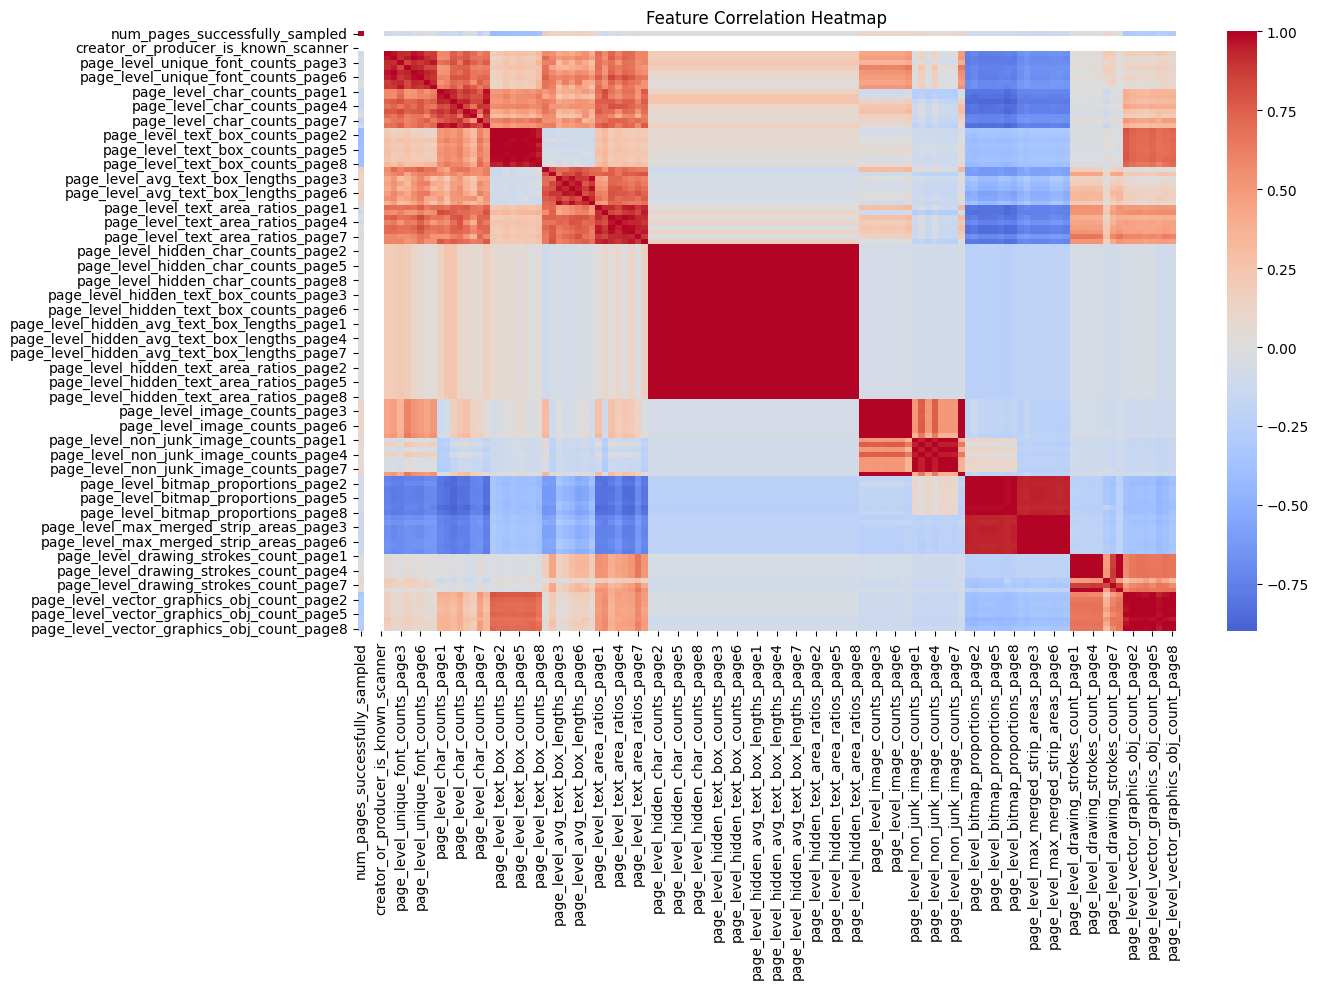

In [67]:

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [69]:
import numpy as np

corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["feat_a", "feat_b", "corr"]
strong_pairs = corr_pairs[corr_pairs["corr"].abs(
) >= 0.8].sort_values("corr", ascending=False)

In [70]:
strong_pairs.head(20)

,feat_a,feat_b,corr
5317,page_level_hidden_avg_text_box_lengths_page2,page_level_hidden_text_area_ratios_page5,1.0
5499,page_level_hidden_avg_text_box_lengths_page5,page_level_hidden_text_area_ratios_page7,1.0
5497,page_level_hidden_avg_text_box_lengths_page5,page_level_hidden_text_area_ratios_page5,1.0
5496,page_level_hidden_avg_text_box_lengths_page5,page_level_hidden_text_area_ratios_page4,1.0
5495,page_level_hidden_avg_text_box_lengths_page5,page_level_hidden_text_area_ratios_page3,1.0
5494,page_level_hidden_avg_text_box_lengths_page5,page_level_hidden_text_area_ratios_page2,1.0
5493,page_level_hidden_avg_text_box_lengths_page5,page_level_hidden_text_area_ratios_page1,1.0
5441,page_level_hidden_avg_text_box_lengths_page4,page_level_hidden_text_area_ratios_page8,1.0
5440,page_level_hidden_avg_text_box_lengths_page4,page_level_hidden_text_area_ratios_page7,1.0
5439,page_level_hidden_avg_text_box_lengths_page4,page_level_hidden_text_area_ratios_page6,1.0


In [ ]:
import re


def strip_page_suffix(name: str) -> str:
    return re.sub(r"_page\d+$", "", name)


feature_importance_df["feature_group"] = (
    feature_importance_df["feature"].apply(strip_page_suffix)
)

page_level_avg = (
    feature_importance_df.groupby("feature_group")["importance"]
    .mean()
    .sort_values(ascending=False)
)


feature_group
page_level_text_area_ratios               0.050793
page_level_char_counts                    0.026761
creator_or_producer_is_known_scanner      0.017402
page_level_max_merged_strip_areas         0.008007
garbled_text_ratio                        0.007710
page_level_bitmap_proportions             0.005917
page_level_non_junk_image_counts          0.004178
page_level_vector_graphics_obj_count      0.004153
page_level_image_counts                   0.004128
page_level_unique_font_counts             0.003785
page_level_avg_text_box_lengths           0.003231
page_level_text_box_counts                0.003213
page_level_drawing_strokes_count          0.002666
num_pages_successfully_sampled            0.002316
page_level_hidden_avg_text_box_lengths    0.001489
page_level_hidden_text_area_ratios        0.001482
page_level_hidden_text_box_counts         0.001238
page_level_hidden_char_counts             0.000530
is_form                                   0.000000
Name: importance,

In [77]:
page_level_avg

feature_group
page_level_text_area_ratios               0.050793
page_level_char_counts                    0.026761
creator_or_producer_is_known_scanner      0.017402
page_level_max_merged_strip_areas         0.008007
garbled_text_ratio                        0.007710
page_level_bitmap_proportions             0.005917
page_level_non_junk_image_counts          0.004178
page_level_vector_graphics_obj_count      0.004153
page_level_image_counts                   0.004128
page_level_unique_font_counts             0.003785
page_level_avg_text_box_lengths           0.003231
page_level_text_box_counts                0.003213
page_level_drawing_strokes_count          0.002666
num_pages_successfully_sampled            0.002316
page_level_hidden_avg_text_box_lengths    0.001489
page_level_hidden_text_area_ratios        0.001482
page_level_hidden_text_box_counts         0.001238
page_level_hidden_char_counts             0.000530
is_form                                   0.000000
Name: importance,